In [1]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained SAM model and processor
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

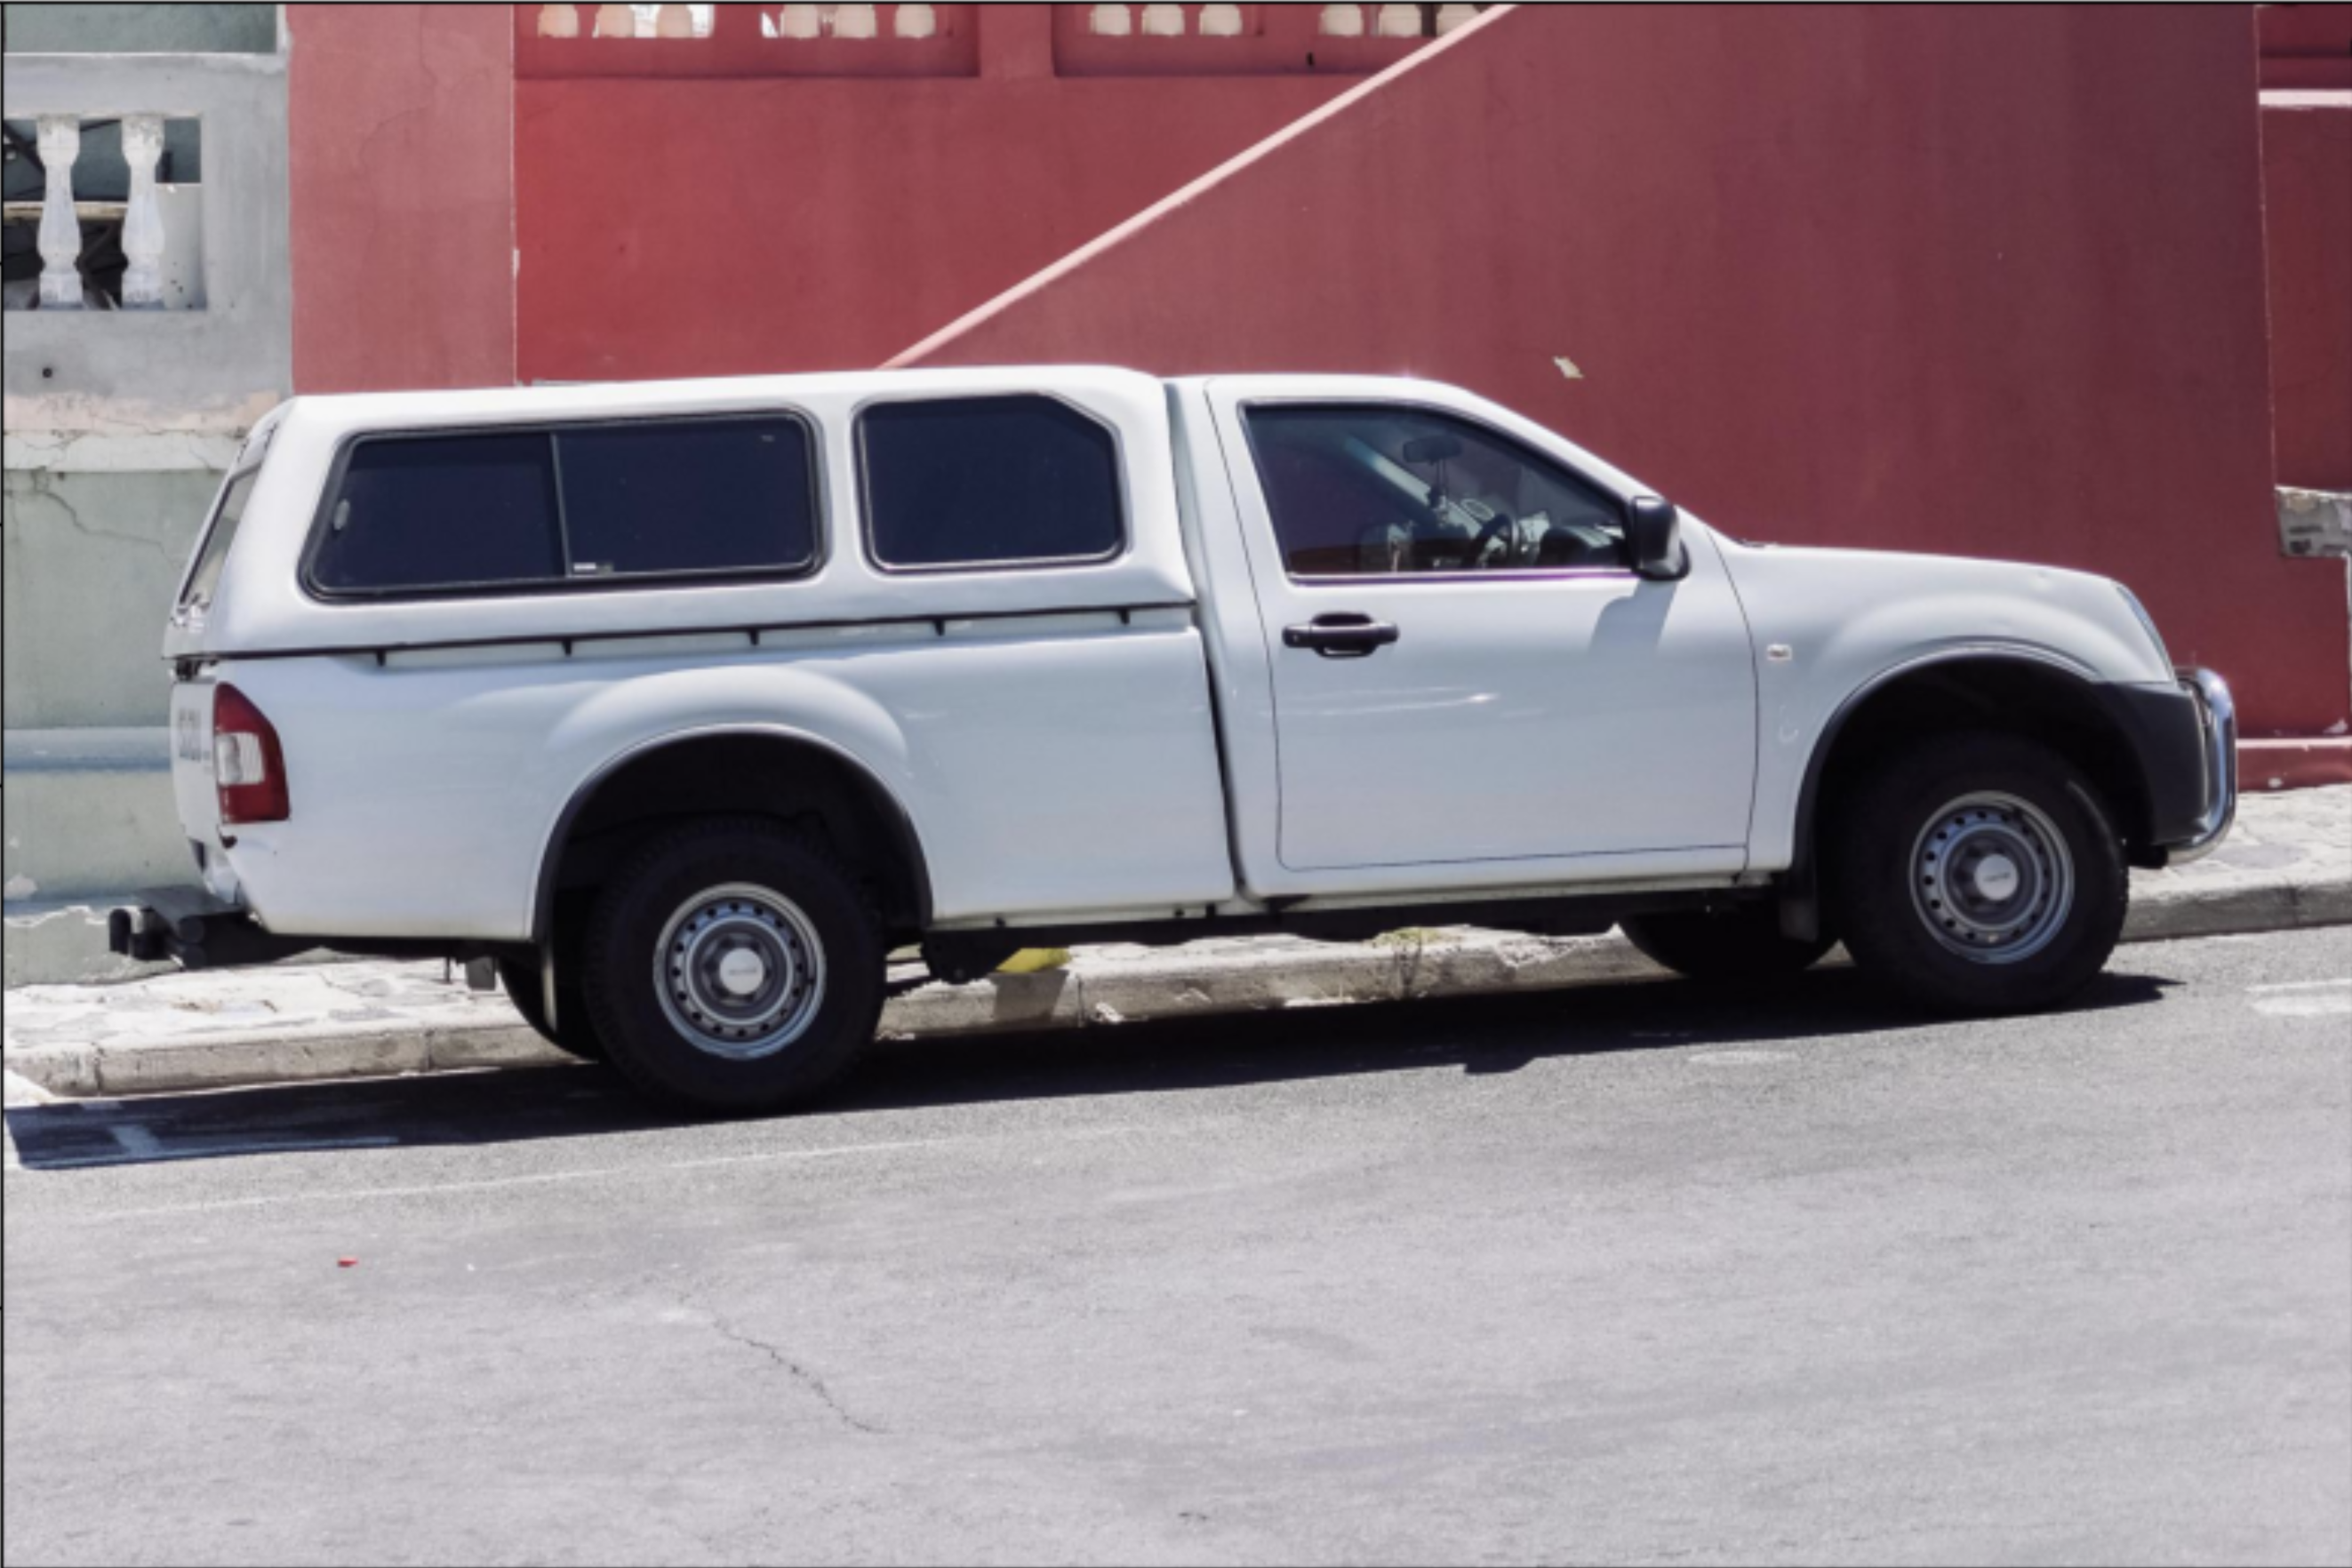

In [2]:
# URL of the image to be segmented
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"

# Load the image
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

raw_image

Define the 2D points that indicate the approximate location of the object of interest in the image.


In [3]:
# Example input points (2D location of a window in the image)
input_points = [[[450, 600]]]

In [6]:
# Process the image and input points
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)

# Perform inference to get the segmentation masks
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the masks
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)

# Get the IoU scores
scores = outputs.iou_scores

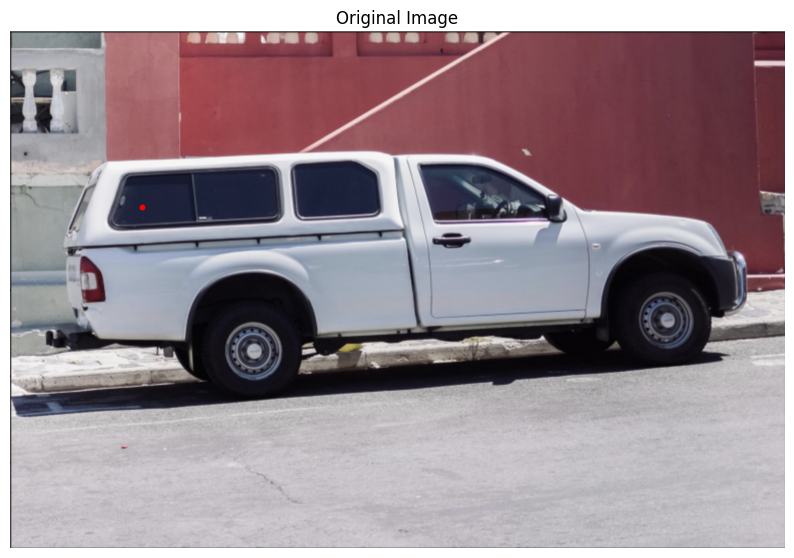

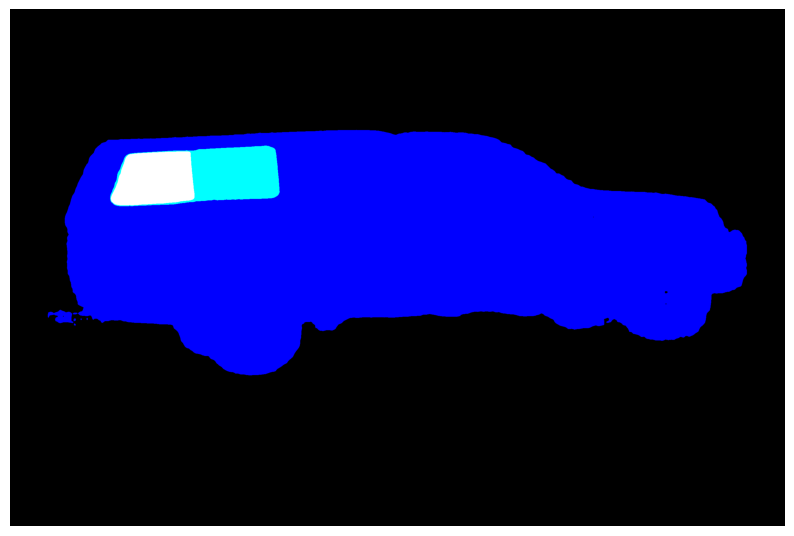

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(raw_image)
# Plot the points
x, y = zip(*input_points[0])
plt.scatter(x, y, c='r', s=10)
plt.axis('off')
plt.title("Original Image")
plt.show()

# Assuming masks[0] is the mask you want to display
mask = masks[0]

# Remove the extra dimension if necessary
if mask.ndim == 4:
    mask = mask.squeeze(0)

# Use permute to rearrange the dimensions to [height, width, channels] if necessary
if mask.shape[0] == 3:
    mask = mask.permute(1, 2, 0)

# Convert True/False to 0/255
binary_image = mask.numpy().astype(np.uint8) * 255

# Display the segmentation mask
plt.figure(figsize=(10, 10))
plt.imshow(binary_image)
plt.axis('off')
#plt.title(f"Segmentation Mask (IoU Score: {scores[0].item():.4f})")
plt.show()